
# Unit 2 Build



In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 100)


In [2]:
# Read data from NYC restaurant inspections Mar 2020 dataset

df = pd.read_csv('/Users/jasimrashid/Projects/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

# Update headers to lower case
df.columns = [i.lower() for i in df.columns]

# Drop all records with null grades 
df = df[df['grade'].isnull()==False]

# TODO: summarize numeric features from null grade records
# TODO: strategy for grades other than A, B, C
# TODO: add this to wrangle function

df.shape

(198130, 26)

In [3]:
# Read NYC census data & merge into restaurant innspection dataframe
nyc_census = pd.read_csv('/Users/jasimrashid/Projects/NYC_census_2010_v2.csv')
nyc_census['census tract'] = nyc_census['census tract'].astype(float)
nyc_census.shape

(2168, 25)

In [4]:
# Clean numeric inputs from NYC_Census: Comma separated numbers stored as string

def clean(x):
    if x=='-':
        return float(0)
    elif isinstance(x, str):
        return float(x.strip('').replace(',',''))
    else:
        return float(0)

column_names = nyc_census.select_dtypes(include='object').columns.tolist()[1:]

nyc_census['persons_per_acre'][-1:]=0

for i in column_names:
    nyc_census[i] = nyc_census[i].apply(clean)

# nyc_census.info()

In [5]:
# Merge inspections dataset and NYC census

df = pd.merge(df,nyc_census, how='inner', on=['boro','census tract'])
df.shape
#TODO: test join condition above

(194904, 49)

In [6]:
df_grouped = df.groupby(['camis','dba','cuisine description','zipcode','community board','council district','census tract','boro','latitude','longitude','inspection date','inspection type','grade date','grade', 'population', 'median_age',
       'total_females', 'total_males', 'population_2000', 'acres',
       'persons_per_acre', 'population_over_17', 'population_under_18',
       'median_age.1', 'white', 'black', 'native', 'asian', 'pacislander',
       'other', 'twoormore', 'hispanic', 'pop_chg_2000_to_2010',
       'pop_chg_2000_to_2010_under_18', 'pop_chg_2000_to_2010_over_18'])['critical flag'].apply(lambda x: (x.isin(['Y'])).sum()).reset_index(name='critical violations').reset_index(level=0,drop=True)

df_restaurants = df_grouped.groupby(['camis','dba','cuisine description','zipcode','community board','council district','census tract','boro','latitude','longitude','population', 'median_age','total_females', 'total_males', 'population_2000', 'acres','persons_per_acre', 'population_over_17', 'population_under_18','median_age.1', 'white', 'black', 'native', 'asian', 'pacislander','other', 'twoormore', 'hispanic', 'pop_chg_2000_to_2010','pop_chg_2000_to_2010_under_18', 'pop_chg_2000_to_2010_over_18'], sort=False,as_index=False)['inspection date', 'inspection type','critical violations','grade date','grade'].first()

df_restaurants.shape

(24261, 36)

In [7]:
#BACKUP
df_grouped_temp = df_grouped.copy()

In [8]:
df_grouped_a = df.groupby(['camis','inspection date','inspection type','grade date','grade','score',
'dba','cuisine description','zipcode','community board','council district','census tract','boro','latitude','longitude', 'population', 'median_age','total_females', 'total_males', 'population_2000', 'acres','persons_per_acre', 'population_over_17', 'population_under_18',
'median_age.1', 'white', 'black', 'native', 'asian', 'pacislander','other', 'twoormore', 'hispanic', 'pop_chg_2000_to_2010','pop_chg_2000_to_2010_under_18','pop_chg_2000_to_2010_over_18'],sort=False, as_index=False)[['violation code']].count()


In [9]:
df_grouped_b = df.groupby(['camis','inspection date'])['critical flag'].apply(lambda x: (x.isin(['Y'])).sum()).reset_index(name='critical violations').reset_index(level=0,drop=True)

In [10]:
df_grouped_a.shape, df_grouped_b.shape

((82004, 37), (82634, 3))

In [11]:
df_grouped = pd.merge(df_grouped_a, df_grouped_b, how='inner', on=['camis','inspection date'])
df_grouped.shape

(82004, 38)

In [12]:
df_grouped['inspection date'] = pd.to_datetime(df_grouped['inspection date'], infer_datetime_format=True)

df_grouped['grade date'] = pd.to_datetime(df_grouped['grade date'], infer_datetime_format=True)
# TODO: add to feature engineering function

In [13]:
df_grouped = df_grouped.sort_values(by = ['camis','inspection date'], ascending=[True, False])

In [14]:
# Adding features for prior-date grade, score, violations, critical violations
df_grouped_len = df_grouped.shape[0]
df_grouped['grade prior']=np.nan
df_grouped['score prior']=np.nan
df_grouped['violations prior']=np.nan
df_grouped['critical violations prior']=np.nan

for i in range(len(df_grouped)-1): #range(df_grouped_len):
    if df_grouped['camis'].iloc[i] == df_grouped['camis'].iloc[i+1]:
        # print(df_grouped['grade'].iloc[i+1])
        df_grouped['grade prior'].iloc[i] = df_grouped['grade'].iloc[i+1]
        df_grouped['score prior'].iloc[i] = df_grouped['score'].iloc[i+1]
        df_grouped['violations prior'].iloc[i] = df_grouped['violation code'].iloc[i+1]
        df_grouped['critical violations prior'].iloc[i] = df_grouped['critical violations'].iloc[i+1]
    # else:
    #     # print(0)
    #     df_grouped['grade_prior'].iloc[i] = 0

# df_grouped['camis'].iloc[1]

In [15]:
df_grouped.shape

(82004, 42)

In [16]:
# BACKUP 
df_restaurants_temp = df_restaurants.copy() #BACKUP
df_temp = df.copy() #BACKUP

In [17]:
# RESTORE
# df_restaurants = df_restaurants_temp
# df = df_temp

In [18]:
df_temp.shape

(194904, 49)

**Pre-Processing**

• N = Not Yet Graded
 
• A = Grade A

• B = Grade B

• C = Grade C

• Z = Grade Pending

• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure

In [85]:
# TEMPORARY - setting df to df_restaurants
df = df_grouped.copy()

In [86]:
zipcodes = pd.read_csv('/Users/jasimrashid/Downloads/zipcodes.csv')
df = pd.merge(df, zipcodes ,how='inner',on='zipcode')
df.shape

(79450, 43)

In [87]:
df.grade.value_counts(dropna=False, normalize=True)

A    0.864556
B    0.078653
C    0.026344
P    0.020629
Z    0.009755
G    0.000038
N    0.000025
Name: grade, dtype: float64

In [88]:
df.shape

(79450, 43)

In [89]:
%%time
# TEMPORARY

# when df at restaurant level --> drop all records where rating is not A, B or C
condition = df['grade'].isin(['A','B','C'])==True
df = df[condition]
df.shape

CPU times: user 35.6 ms, sys: 19.2 ms, total: 54.8 ms
Wall time: 62 ms


(77031, 43)

In [90]:
# GRADES INTO A AND OTHER
# df['grade1'] =
df[df['grade']!='A']['grade']='not perfectly healthy'

def clean_grades(grade):
    if grade == 'A':
        return 'A'
    else:
        return 'other'

df['grade'] = df['grade'].apply(clean_grades)

In [91]:
# Target label 'no-go'
# TODO: Find a better label
df['no-go'] = df['grade']!='A'
df['no-go'].value_counts(normalize=True)

False    0.891706
True     0.108294
Name: no-go, dtype: float64

**Train / Validate / Test Split**

In [92]:
from sklearn.model_selection import train_test_split


df = df.copy()


train, test = train_test_split(df, train_size=0.8, test_size=.2, stratify=df['no-go'], random_state=42)
# train, test = train_test_split(df, train_size=0.8, test_size=.2, random_state=42)

#2
train, val = train_test_split(train, train_size=0.8, test_size=.2, stratify=train['no-go'], random_state=42)
# train, val = train_test_split(train, train_size=0.8, test_size=.2, random_state=42)

# val = df[(df['inspection year-month']>=201801) & (df['inspection year-month']<201903)]

print('before: ',df.shape)
print('train: ',train.shape)
print('val: ',val.shape)
print('test: ',test.shape)


# ** UPDATE:
# train_val_test_split(df)
# train_val_test_split(df_restaurants)



before:  (77031, 44)
train:  (49299, 44)
val:  (12325, 44)
test:  (15407, 44)


In [57]:
#RECUCING TRAIN SIZE


# train, leaftout = train_test_split(train, train_size=.1, test_size=.8, stratify=train['no-go'], random_state=42)

In [93]:
print('train: ',train.shape)

train:  (49299, 44)


In [26]:
def wrangle(df):

    df = df.copy()

    return df

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)



In [94]:
def divide_by(vec):
    x=vec[0]
    y=vec[1]
    if y==0:
        return np.nan
    else:
        return x/y

def engineer_features(df):

    df = df.copy()

     
    # TODO: Add to engineer features

    df['zipcode']=(df['zipcode'].astype(int)).astype(str)
    df['community board']=(df['community board'].astype(int)).astype(str)
    df['council district']=(df['council district'].astype(int)).astype(str)
    df['census tract']=(df['census tract'].astype(int)).astype(str)

    as_of_date = pd.to_datetime('2020-03-31')
    # df['days_since_inspection'] = (as_of_date - pd.to_datetime(df['inspection date']))/np.timedelta64(1,'D')

    df['grade date']=(df['grade date'].astype(str))
    df['female to male'] = df['total_females']/df['total_males']
    df['adults to minor'] = df[['population_over_17','population_under_18']].apply(divide_by, axis=1)

    df['inspection date year'] = df['inspection date'].dt.year
    df['inspection date month']=train['inspection date'].dt.month
    df['inspection date day']=train['inspection date'].dt.day
    df['inspection date dayofweek']=train['inspection date'].dt.dayofweek

    
    return df


# train = engineer_features(df)

train = engineer_features(train)
val = engineer_features(val)
test = engineer_features(test)


In [95]:
train['inspection date']=train['inspection date'].astype(str)
val['inspection date']=val['inspection date'].astype(str)
test['inspection date']=test['inspection date'].astype(str)

In [29]:
# train.info()

In [99]:
features    

['inspection date',
 'dba',
 'zipcode',
 'council district',
 'census tract',
 'boro',
 'population',
 'total_females',
 'total_males',
 'population_2000',
 'persons_per_acre',
 'population_over_17',
 'population_under_18',
 'pop_chg_2000_to_2010',
 'pop_chg_2000_to_2010_over_18',
 'grade prior',
 'score prior',
 'violations prior',
 'critical violations prior',
 'neighborhood',
 'female to male',
 'adults to minor',
 'inspection date month',
 'inspection date day',
 'inspection date dayofweek']

In [118]:
#CLASSIFICATION MODEL

target = ['no-go']
# target='grade'

#mandatory exclusions:
leakage=['score','grade','violation code','critical violations']

#unethical
race = ['white','black','native','asian','pacislander','other','twoormore','hispanic']

#optional
irrelevant = ['camis', 'grade date','median_age.1']

#play around #1
col6_excl = ['inspection type','cuisine description','community board','latitude','longitude','median_age','acres','pop_chg_2000_to_2010_under_18','violation code','critical violations', 'inspection date year']

#super-simplify for dash-app

additional = ['total_females','total_males','population_over_17','population_under_18','dba']

mvp_drop = ['population_2000','pop_chg_2000_to_2010_over_18','council district','boro','population','pop_chg_2000_to_2010', 'census tract', 'inspection date','zipcode','inspection date year', 'inspection date day']

drop_columns = target + leakage + race + irrelevant + col6_excl + additional + mvp_drop

# train_features = train.drop(columns = [target,'score', 'camis','action','inspection type','violation description','violation code', 'critical flag','boro',
# 'latitude','longitude',
# 'bbl','bin'])

# train_features = train.drop(columns = [target, 'camis','critical violations','grade','inspection type','violation code','score','grade date','white','asian','black','pacislander','other','twoormore','hispanic','dba','latitude','longitude','population_2000','pop_chg_2000_to_2010_under_18','pop_chg_2000_to_2010_over_18','total_females','total_males','population_over_17','population_under_18']) #for restaurant_ratings scenario only

# Drop target
train_features = train.drop(columns = drop_columns)

# , 'inspection date', 'violation code', 'critical violations'])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 84].index.tolist()

# features = numeric_features + categorical_features #scenario 1

features = train_features.columns.to_list()# + numeric_features# scenario 4 INCLUDE ALL FEATURES 


In [98]:
#REGRESSION MODEL

target = ['score']
# target='grade'

#mandatory exclusions:
leakage=['grade','violation code','critical violations','no-go']

#unethical
race = ['white','black','native','asian','pacislander','other','twoormore','hispanic']

#optional
irrelevant = ['camis', 'grade date','median_age.1']

#play around #1
col6_excl = ['inspection type','cuisine description','community board','latitude','longitude','median_age','acres','pop_chg_2000_to_2010_under_18','violation code','critical violations', 'inspection date year']

#super-simplify for dash-app

additional = ['total_females','total_males','population_over_17','population_under_18','dba']

mvp_drop = ['population_2000','pop_chg_2000_to_2010_over_18','council district','boro','population','pop_chg_2000_to_2010', 'census tract', 'inspection date','zipcode','inspection date year', 'inspection date day']

drop_columns = target + leakage + race + irrelevant + col6_excl

# train_features = train.drop(columns = [target,'score', 'camis','action','inspection type','violation description','violation code', 'critical flag','boro',
# 'latitude','longitude',
# 'bbl','bin'])

# train_features = train.drop(columns = [target, 'camis','critical violations','grade','inspection type','violation code','score','grade date','white','asian','black','pacislander','other','twoormore','hispanic','dba','latitude','longitude','population_2000','pop_chg_2000_to_2010_under_18','pop_chg_2000_to_2010_over_18','total_females','total_males','population_over_17','population_under_18']) #for restaurant_ratings scenario only

# Drop target
train_features = train.drop(columns = drop_columns)

# , 'inspection date', 'violation code', 'critical violations'])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 84].index.tolist()

# features = numeric_features + categorical_features #scenario 1

features = train_features.columns.to_list()# + numeric_features# scenario 4 INCLUDE ALL FEATURES 


In [289]:
X_train['adults to minor'].describe()

count    48893.000000
mean         7.821763
std         18.450208
min          0.663964
25%          3.415546
50%          4.941489
75%          9.167969
max        750.000000
Name: adults to minor, dtype: float64

In [119]:
features

['persons_per_acre',
 'grade prior',
 'score prior',
 'violations prior',
 'critical violations prior',
 'neighborhood',
 'female to male',
 'adults to minor',
 'inspection date month',
 'inspection date dayofweek']

In [120]:
X_train = train[features]
y_train = train[target[0]]
X_val = val[features]
y_val = val[target[0]]
X_test = test[features]
y_test = test[target[0]]

In [188]:
X_train['zipcode'].value_counts(normalize=True).keys()

Index(['10019', '10003', '10036', '10013', '10001', '10002', '10022', '11201',
       '10011', '10012',
       ...
       '12345', '10000', '10158', '10173', '10177', '10123', '10155', '10176',
       '10080', '11242'],
      dtype='object', length=220)

In [311]:
col9 = features

In [138]:
X_train = train[col9]
y_train = train[target]
X_val = val[col9]
y_val = val[target]
X_test = test[col9]
y_test = test[target]

NameError: name 'col9' is not defined

In [218]:
y_train_temp = y_train.copy()
y_val_temp = y_val.copy()
y_test_temp = y_test.copy()

In [69]:
# Custom-selected feature set
col6 = ['cuisine description','dba','boro','days_since_inspection','median_age.1','total_females','council district','census tract','population_over_17','total_males','grade date','persons_per_acre','inspection date','population','pop_chg_2000_to_2010_over_18','population_2000','population_under_18','zipcode','pop_chg_2000_to_2010','median_age']

In [834]:
# col6.remove('grade date')
# col6.remove('zipcode')
# col6.remove('census tract')

col6.remove('dba')

In [824]:
col7

['cuisine description',
 'zipcode',
 'community board',
 'census tract',
 'median_age',
 'total_females',
 'population_2000',
 'acres',
 'persons_per_acre',
 'population_over_17',
 'population_under_18',
 'pop_chg_2000_to_2010',
 'pop_chg_2000_to_2010_under_18',
 'pop_chg_2000_to_2010_over_18',
 'inspection date',
 'days_since_inspection']

Predictive Models

In [519]:
model_record =[[]]

In [520]:
# Save models
def record_model():
    i=len(model_record)
    model_record[i-1].append(model)
    model_record[i-1].append(score_test)
    model_record[i-1].append(score_val)
    model_record[i-1].append(roc_auc)
    model_record.append([])
    return model_record

**Baseline**

In [134]:
#TODO
from sklearn.metrics import accuracy_score
# y_train.value_counts(normalize=True)
majority_class = y_train.mode()[0]

# Test Set
y_pred = [majority_class]*len(y_train)
print("Baseline - Test Accuracy: ", accuracy_score(y_train, y_pred))

# Validation Set
majority_class = y_val.mode()[0]
y_pred = [majority_class]*len(y_val)
print("Baseline - Validation Accuracy: ", accuracy_score(y_val, y_pred))

Baseline - Test Accuracy:  0.8917016572344266
Baseline - Validation Accuracy:  0.891683569979716


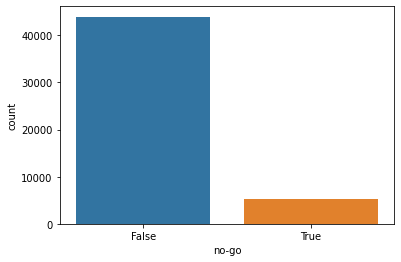

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.countplot(y_train);

In [ ]:
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    SelectKBest(f_regression, k=5),
    verbose=10, 
    Ridge(alpha=1.0)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

In [116]:
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean')
    
    # SelectKBest(f_regression, k=20), 
    # Ridge(alpha=1.0)
)

# # k = 3
# # scores = cross_val_score(pipeline, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
# mae = mean_absolute_error(y_test, y_pred)
# print(f'Test MAE: ${mae:,.0f}')

# print(f'MAE for {k} folds:', -scores)

AttributeError: 'SimpleImputer' object has no attribute 'predict'

**Logistic Regression**

In [131]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    LogisticRegression(max_iter=1000)
)

pipeline.fit(X_train, y_train)
print("Linear Regression - Train Accuracy: ",  pipeline.score(X_train, y_train))
print("Linear Regression - Validation Accuracy: ",  pipeline.score(X_val, y_val))


Linear Regression - Train Accuracy:  0.8910931256212093
Linear Regression - Validation Accuracy:  0.8908722109533469


In [98]:
import category_encoders as ce
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

gapminder = px.data.gapminder()
X = gapminder[['year', 'continent']]
y = gapminder['lifeExp']

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    LinearRegression()
)

pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['continent'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [83]:
from joblib import dump
dump(pipeline, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [84]:
!ls -lh pipeline.joblib

-rw-r--r--  1 jasimrashid  staff   1.6M May 29 10:03 pipeline.joblib


In [73]:
# Get versiokns
import joblib
import sklearn
import category_encoders as ce
import xgboost
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')

joblib==0.14.1
scikit-learn==0.22.1
category_encoders==2.2.2
xgboost==1.1.0


In [39]:
pipeline

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['grade prior', 'neighborhood'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'grade prior',
                                          'data_type': dtype('O'),
                                          'mapping': B      1
A      2
NaN    3
C      4
P      5
dtype: int64},
                                         {'col': 'neighborhood',
                                          'data_type': dtype('O'),
                                          'mapping': High Bridge and Morrisania        1
Greenwich Village and So...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                     

In [82]:

# print('hello')

def predict(neighborhood,grade_prior, score_prior, violations_prior, critical_violations_prior,persons_per_acre,female_to_male,adults_to_minor, inspection_date_month, inspection_date_dayofweek):
    
    # print('A')
    # print('hello')
    df = pd.DataFrame(columns=[ 'neighborhood','grade prior','score prior','violations prior','critical violations prior','persons_per_acre','female to male','adults to minor', 'inspection date month','inspection date dayofweek'], data=[[neighborhood,grade_prior, score_prior, violations_prior, critical_violations_prior,persons_per_acre,female_to_male,adults_to_minor, inspection_date_month,inspection_date_dayofweek]])
      
    # print(pipeline.predict(df)[0])
    # y_pred = pipeline.predict(df)[0]
    # print(df)

    if y_pred == 'True':
        y_pred_proba = pipeline.predict_proba(df)[0][0]
        return f'{y_pred_proba*100:.0f}% probability'# of a {y_pred}'
    else:
        y_pred_proba = pipeline.predict_proba(df)[0][1]
        return f'{y_pred_proba*100:.0f}% probability'# {y_pred}'

predict('Lower Manhattan','A',10,10,9,200,1,20,1,2)


'37% probability'

In [354]:
predict('Lower Manhattan','A',10,10,9,200,1,20,1,2)

    

1


In [107]:
def predict(year, continent):
    df = pd.DataFrame(
        columns=['year', 'continent'], 
        data=[[year, continent]]
    )
    y_pred = pipeline.predict(df)[0]
    return f'{y_pred:.0f} years'

In [104]:
# SCENARIO 1
# Decision tree w/ OneHot Encoding
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42)    
)

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
print(pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_val)


KeyboardInterrupt: 

In [169]:
# SCENARIO 2
# Decision tree w/ Ordinal Encoding

import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42)
    
)

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
print(pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_val)


1.0
0.7866404715127702


In [168]:
# SCENARIO 3
# Random Forest with Ordinal Encoding

import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42)
)

pipeline.fit(X_train, y_train)
score_test = pipeline.score(X_train, y_train)
score_val = pipeline.score(X_val, y_val)
print(score_test)
print(score_val)
y_pred = pipeline.predict(X_val)


0.9909734477372766
0.8801622718052738


In [127]:
# SCENARIO 4
# XGB Classifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
import pandas as pd
import seaborn as sns

# titanic = sns.load_dataset('titanic')
# X = titanic[['age', 'class', 'deck', 'embarked', 'fare', 'sex']]
# y = titanic['survived']

encoder = ce.OrdinalEncoder(handle_unknown='ignore')
imputer = SimpleImputer(strategy='mean')

X_train_transformed = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_transformed) #OPT
X_val_transformed = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_transformed) #OPT


In [128]:
# XGBoost #1 
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

model = XGBClassifier()
model.fit(X_train_imputed, y_train)
cross_val_score(model, X_val_imputed, y_val, scoring='accuracy', cv=10, n_jobs=-1)


# feature_names mismatch:
#  ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']
 
#   ['cuisine description', 'dba', 'boro', 'days_since_inspection', 'median_age.1', 'total_females', 'council district', 'census tract', 'population_over_17', 'total_males', 'grade date', 'persons_per_acre', 'inspection date', 'population', 'pop_chg_2000_to_2010_over_18', 'population_2000', 'population_under_18', 'zipcode', 'pop_chg_2000_to_2010', 'median_age']

# expected f13, f11, f0, f16, f7, f1, f5, f6, f19, f18, f3, f2, f17, f12, f10, f4, f15, f9, f14, f8 in input data

# training data did not have the following fields: 
# persons_per_acre, pop_chg_2000_to_2010, cuisine description, pop_chg_2000_to_2010_over_18, median_age.1, population_2000, inspection date, median_age, grade date, population_under_18, population_over_17, council district, days_since_inspection, total_males, total_females, census tract, population, dba, boro, zipcode

array([0.88158962, 0.88240065, 0.88158962, 0.87996756, 0.88240065,
       0.88068182, 0.88961039, 0.88311688, 0.87662338, 0.88798701])

In [ ]:
# XGBoost Tuned

model = XGBClassifier(
    learning_rate = .5,
    n_estimators = 1000,
    max_depth = 7,
    
    # the below params fixed an error 
    # TODO: research the parameters below
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    nthread=4,
    scale_pos_weight=1,
    seed=27,

    n_jobs=-1
    num_class = 2
)

eval_set = [(X_train_imputed, y_train),
            (X_val_imputed, y_val)]

model.fit(X_train_imputed, y_train,eval_set=eval_set,eval_metric='merror',early_stopping_rounds=100) #OPT
cross_val_score(model, X_val_imputed, y_val, scoring='accuracy', cv=10, n_jobs=-1)

# TODO: random search CV - play around with hyper parameter + save model results


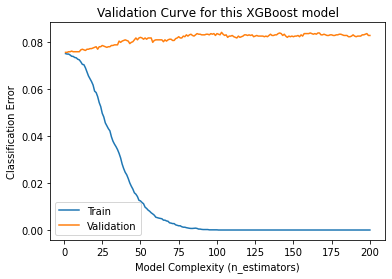

In [939]:
results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
#plt.ylim((0.18, 0.22)) # Zoom in
#plt.legend();

In [940]:
# Cannot easily be run on XGBoost

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_val_transformed, y_val, values_format='.0f', xticks_rotation='vertical')

from sklearn.metrics import plot_confusion_matrix
# plot_confusion_matrix(model, X_val_transformed, y_val, values_format='.0f', xticks_rotation='vertical')

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19'] ['cuisine description', 'dba', 'boro', 'days_since_inspection', 'median_age.1', 'total_females', 'council district', 'census tract', 'population_over_17', 'total_males', 'grade date', 'persons_per_acre', 'inspection date', 'population', 'pop_chg_2000_to_2010_over_18', 'population_2000', 'population_under_18', 'zipcode', 'pop_chg_2000_to_2010', 'median_age']
expected f13, f11, f0, f16, f7, f1, f5, f6, f19, f18, f3, f2, f17, f12, f10, f4, f15, f9, f14, f8 in input data
training data did not have the following fields: persons_per_acre, pop_chg_2000_to_2010, cuisine description, pop_chg_2000_to_2010_over_18, median_age.1, population_2000, inspection date, median_age, grade date, population_under_18, population_over_17, council district, days_since_inspection, total_males, total_females, census tract, population, dba, boro, zipcode

In [941]:
X_train.columns

Index(['cuisine description', 'dba', 'boro', 'days_since_inspection',
       'median_age.1', 'total_females', 'council district', 'census tract',
       'population_over_17', 'total_males', 'grade date', 'persons_per_acre',
       'inspection date', 'population', 'pop_chg_2000_to_2010_over_18',
       'population_2000', 'population_under_18', 'zipcode',
       'pop_chg_2000_to_2010', 'median_age'],
      dtype='object')

In [172]:
# SCENARIO 4
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

precision    recall  f1-score   support

       False       0.89      1.00      0.94     11357
        True       0.28      0.01      0.02      1368

    accuracy                           0.89     12725
   macro avg       0.58      0.50      0.48     12725
weighted avg       0.83      0.89      0.84     12725



In [149]:
# ROC for non-XGB
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_val)[:, -1]  # Probability for the last class
roc_auc = roc_auc_score(y_val, y_pred_proba) #SCENARIO 4 - 0.5775
print(roc_auc)
# y_pred_proba[:5]

0.5891099160626105


In [140]:
#ROC for XGB

from sklearn.metrics import roc_auc_score
y_pred_proba = model.predict_proba(X_val_imputed)[:, -1]  # Probability for the last class
roc_auc = roc_auc_score(y_val, y_pred_proba) #SCENARIO 4 - 0.5775
print(roc_auc)
# y_pred_proba[:5]

0.614772878306121


In [181]:
pipeline.predict_proba(X_val)

array([[0.98, 0.02],
       [0.92, 0.08],
       [0.88, 0.12],
       ...,
       [0.89, 0.11],
       [0.97, 0.03],
       [0.99, 0.01]])

In [144]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [145]:
pipeline

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['grade prior', 'neighborhood'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'grade prior',
                                          'data_type': dtype('O'),
                                          'mapping': B      1
A      2
NaN    3
C      4
P      5
dtype: int64},
                                         {'col': 'neighborhood',
                                          'data_type': dtype('O'),
                                          'mapping': High Bridge and Morrisania        1
Greenwich Village and So...
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
               

In [740]:
X_val_transformed.shape

(3757, 16)

In [690]:
pd.DataFrame(X_val_transformed)

,cuisine description,dba,boro,days_since_inspection,median_age.1,total_females,council district,census tract,population_over_17,total_males,grade date,persons_per_acre,inspection date,population,pop_chg_2000_to_2010_over_18,population_2000,population_under_18,zipcode,pop_chg_2000_to_2010,median_age
4780,4,2785.0,5,1148.0,38.8,1492.0,41,731.0,2311.0,1458.0,548.0,27.2,548.0,2950.0,-31.0,3118.0,639.0,41.0,-168.0,38.8
16015,18,NaN,4,1125.0,37.5,2201.0,11,360.0,3514.0,2181.0,143.0,54.8,143.0,4382.0,444.0,3891.0,868.0,23.0,491.0,37.5
22967,27,NaN,2,76.0,36.6,1661.0,3,146.0,2530.0,1380.0,350.0,81.8,350.0,3041.0,37.0,2955.0,511.0,3.0,86.0,36.6
1163,21,NaN,2,1092.0,30.3,1585.0,17,121.0,2495.0,1714.0,454.0,56.2,454.0,3299.0,167.0,3229.0,804.0,117.0,70.0,30.3
18940,3,NaN,1,25.0,30.0,4048.0,15,137.0,7275.0,3566.0,669.0,176.6,669.0,7614.0,837.0,6753.0,339.0,5.0,861.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,7,885.0,2,986.0,30.4,4166.0,6,265.0,6074.0,3459.0,47.0,135.3,47.0,7625.0,738.0,7681.0,1551.0,131.0,-56.0,30.4
4744,15,NaN,1,77.0,37.0,2923.0,5,634.0,5830.0,3415.0,241.0,155.0,241.0,6338.0,1466.0,4626.0,508.0,61.0,1712.0,37.0
16604,3,NaN,2,200.0,39.6,1045.0,51,1004.0,1513.0,884.0,691.0,37.5,691.0,1929.0,-74.0,2186.0,416.0,164.0,-257.0,39.6
9685,3,NaN,1,420.0,43.0,3873.0,5,58.0,8010.0,4681.0,168.0,194.3,168.0,8554.0,309.0,8288.0,544.0,7.0,266.0,43.0


In [614]:
len(X_train.columns.to_list())

26

In [527]:
# RECORD MODEL
record_model()

[[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='auto',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=100,
                         n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                         warm_start=False),
  0.9998003593531644,
  0.9238754325259516,
  0.5529466751560326],
 [XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, gamma=None,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints

In [152]:
# Are you curious to better understand this?

# "The ROC curve is created by plotting the true positive rate (TPR)
# against the false positive (FPR) at various threshold settings."

# Use sklearn to calculate TPR & FPR at various thresholds
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [151]:
# # See the results in a table
# pd.DataFrame({
#     'False Positive Rate': fpr, 
#     'True Positive Rate': tpr, 
#     'Threshold': thresholds
# })

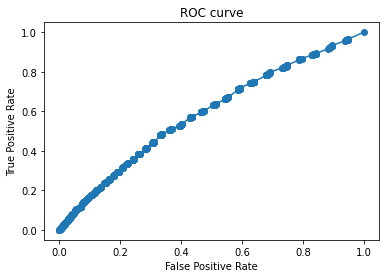

In [153]:
# SCENARIO 4
# See the results on a plot.
# This is the "Receiver Operating Characteristic curve"
import matplotlib.pyplot as plt
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

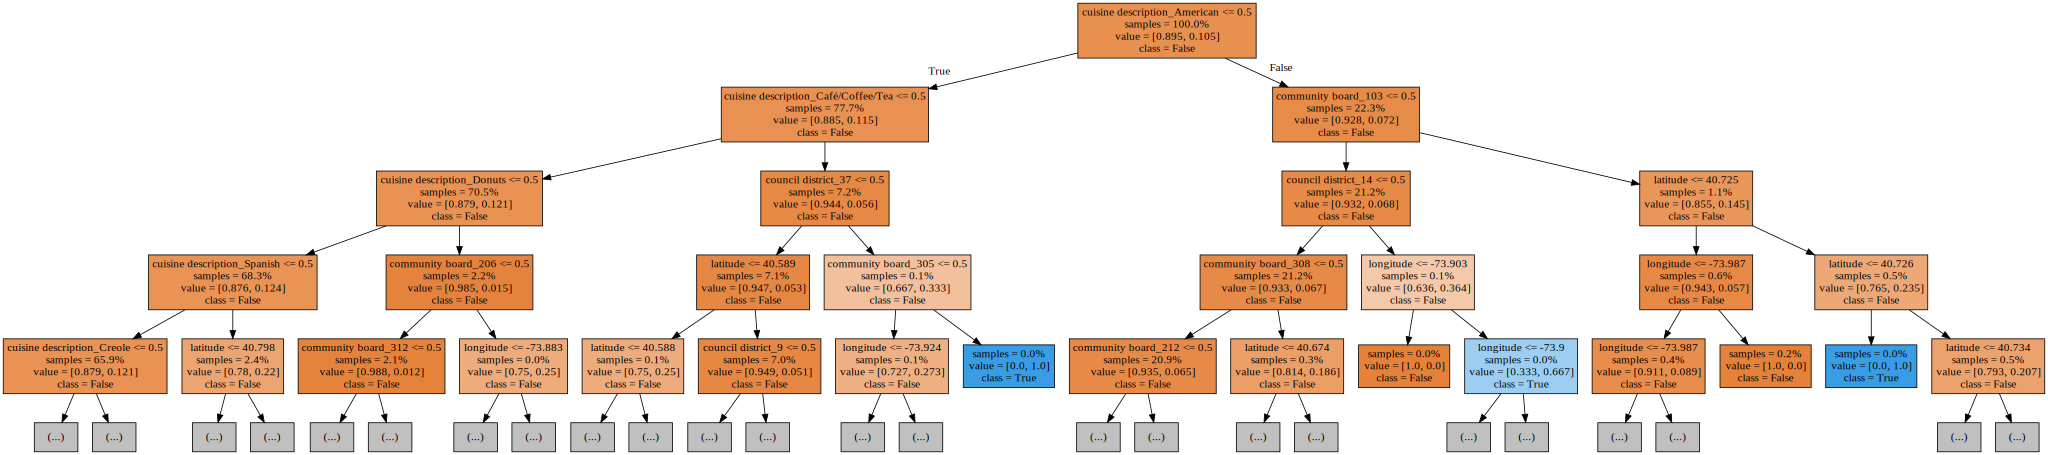

In [605]:
# SCENARIO 1

# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
from sklearn.tree import export_graphviz

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=4, 
                           feature_names=encoded_columns,
                           class_names=y_train.unique().astype(str), 
                        #    class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True )
                        #    rounded=True)   
display(graphviz.Source(dot_data))

In [662]:
y_train.value_counts(normalize=True)

False    0.894757
True     0.105243
Name: no-go, dtype: float64

In [161]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

precision    recall  f1-score   support

           A       0.99      0.97      0.98     19209
           B       0.88      0.97      0.92      3026
           C       0.90      0.92      0.91      1077
           G       1.00      1.00      1.00         1
           N       1.00      1.00      1.00        10
           P       0.63      0.51      0.56       345
           Z       0.33      1.00      0.50         1

    accuracy                           0.96     23669
   macro avg       0.82      0.91      0.84     23669
weighted avg       0.96      0.96      0.96     23669



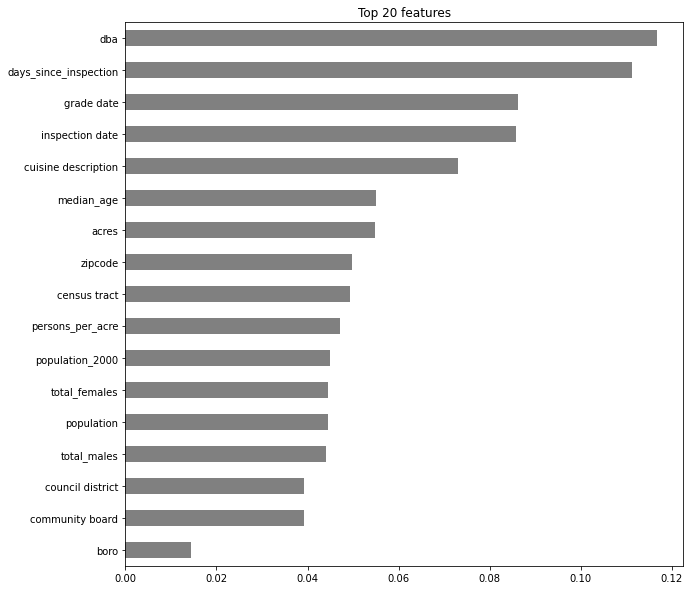

In [28]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [644]:
column  = 'latitude'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without latitude: 0.8938691396187533
Validation Accuracy with latitude: 0.895414734672849
Drop-Column Importance for latitude: 0.0015455950540957941


In [670]:
# Eli5 pre-step: Random Forest Model Fit

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [176]:
# Eli5 pre-step: XGBoost
import category_encoders as ce
from sklearn.impute import SimpleImputer
encoder = ce.OrdinalEncoder(handle_unknown='ignore')
imputer = SimpleImputer(strategy='mean')
X_train_transformed = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_transformed)
X_val_transformed = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_transformed)

model = XGBClassifier()
model.fit(X_train_imputed, y_train)

# cross_val_score(model, X_val_transformed, y_val, scoring='accuracy', cv=10, n_jobs=-1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [177]:
# Ignore warnings
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    # pipeline,
    model,
    scoring='accuracy',
    n_iter=5,  # Run each permutation 5 times and take the average
    random_state=42  # Seed for reproducibility and tune our model
)

# permuter.fit(X_val, y_val)
permuter.fit(X_val_imputed, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_delta_step=0, max_depth=6,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n_jobs=0,
                                              num_parallel_tree=1,
                                              objective='binary:logistic',
    

In [156]:
feature_names = X_val.columns.tolist()
cols = pd.Series(permuter.feature_importances_, feature_names).sort_values(
    ascending=False)
cols

score prior                  0.006669
critical violations prior    0.006085
grade prior                  0.000389
inspection date dayofweek    0.000000
inspection date month        0.000000
female to male              -0.000146
persons_per_acre            -0.000357
adults to minor             -0.000406
violations prior            -0.000487
neighborhood                -0.000698
dtype: float64

In [157]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0067 ± 0.0014,score prior
0.0061 ± 0.0007,critical violations prior
0.0004 ± 0.0007,grade prior
0 ± 0.0000,inspection date dayofweek
0 ± 0.0000,inspection date month
-0.0001 ± 0.0008,female to male
-0.0004 ± 0.0011,persons_per_acre
-0.0004 ± 0.0006,adults to minor
-0.0005 ± 0.0011,violations prior
-0.0007 ± 0.0005,neighborhood


In [566]:
# Drop bottom 5 features
col1 = cols[:-2].index.to_list()
col2 = cols[:-5].index.to_list()
col3 = cols[:-10].index.to_list()
col4 = cols[:-15].index.to_list()
col5 = cols[:-20].index.to_list()

In [ ]:
pop_chg_2000_to_2010_under_18

In [162]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [188]:
pd.DataFrame(X_val_imputed)

,0,1,2,3,4,5,6,7,8,9
0,61.7,3.0,10.637764,2.321234,1.184869,15.0,0.979771,6.123418,6.191059,2.026147
1,206.3,2.0,12.000000,3.000000,2.000000,4.0,0.991609,18.950431,6.191059,2.026147
2,131.8,2.0,11.000000,3.000000,1.000000,19.0,1.018904,15.914027,6.191059,2.026147
3,28.3,3.0,10.637764,2.321234,1.184869,22.0,1.045279,2.673010,6.191059,2.026147
4,54.6,2.0,12.000000,2.000000,1.000000,21.0,1.304878,4.266254,6.191059,2.026147
...,...,...,...,...,...,...,...,...,...,...
12320,96.3,3.0,10.637764,2.321234,1.184869,31.0,1.170821,2.855469,6.191059,2.026147
12321,78.9,3.0,10.637764,2.321234,1.184869,21.0,1.290143,2.925068,6.191059,2.026147
12322,25.5,1.0,25.000000,5.000000,3.000000,4.0,0.509434,69.000000,6.191059,2.026147
12323,184.0,2.0,9.000000,2.000000,1.000000,14.0,1.296338,13.629295,6.191059,2.026147


In [206]:
from pdpbox.pdp import pdp_isolate, pdp_plot

# feature = 'score prior'
feature = 'persons_per_acre'
# X_val.columns
# pd.DataFrame(X_val_imputed,columns=X_val.columns)

isolated = pdp_isolate(
    model=pipeline,
    dataset=pd.DataFrame(X_val_imputed,columns=X_val.columns),
    model_features = X_val.columns,
    feature=feature
)

In [170]:
X_val.columns

Index(['persons_per_acre', 'grade prior', 'score prior', 'violations prior',
       'critical violations prior', 'neighborhood', 'female to male',
       'adults to minor', 'inspection date month',
       'inspection date dayofweek'],
      dtype='object')

In [421]:
X_train.columns

Index(['dba', 'cuisine description', 'zipcode', 'community board',
       'council district', 'census tract', 'boro', 'population', 'median_age',
       'total_females', 'total_males', 'population_2000', 'acres',
       'persons_per_acre', 'population_over_17', 'population_under_18',
       'median_age.1', 'white', 'black', 'native', 'asian', 'pacislander',
       'other', 'twoormore', 'hispanic', 'pop_chg_2000_to_2010',
       'pop_chg_2000_to_2010_under_18', 'pop_chg_2000_to_2010_over_18',
       'inspection date', 'grade date', 'days_since_inspection'],
      dtype='object')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a572aadd0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a57297450>})

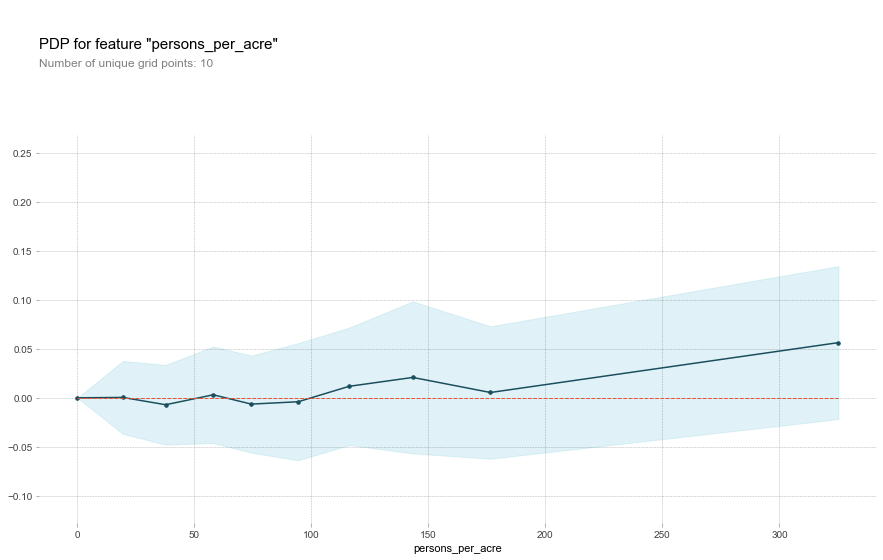

In [207]:
pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a626946d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a583f68d0>})

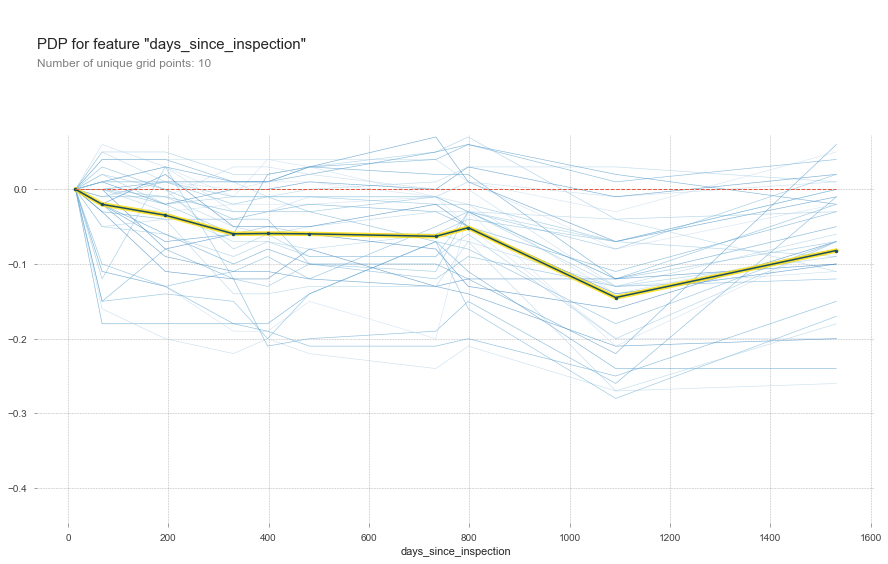

In [757]:
pdp_plot(isolated, feature_name = feature, plot_lines=True, frac_to_plot=0.01)
# plt.xlim(())

In [716]:
np.timedelta64(1,'D')

numpy.timedelta64(1,'D')

In [174]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [173]:
# X_train['population']
# TODO: ADD TO FEATURE ENGINEERING
X_train['population'] = X_train['population'].replace({',':''},regex=True).apply(pd.to_numeric,1).astype(float)

X_val['population'] = X_val['population'].replace({',':''},regex=True).apply(pd.to_numeric,1).astype(float)

In [204]:
# features = ['critical violations prior', 'score prior']
features = ['female to male', 'adults to minor']

interaction = pdp_interact(
    model=pipeline,
    dataset=pd.DataFrame(X_val_imputed,columns=X_val.columns),
    model_features=X_val.columns,
    features=features
)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x130e29450>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a5459aa50>})

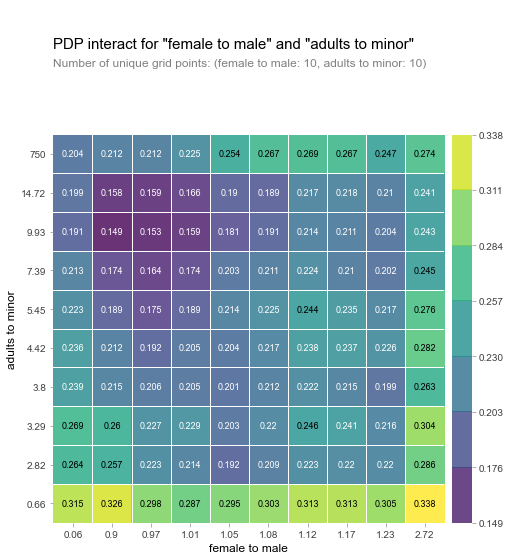

In [205]:
pdp_interact_plot(interaction, plot_type='grid',
                  feature_names=features)

In [59]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap_values# Why did the model predict this?
# Look at a Shapley Values Force Plot

NameError: name 'row' is not defined

In [776]:
census_data = pd.read_csv('/Users/jasimrashid/Projects/nyc_census_tracts.csv')
census_data = census_data.rename(columns={'CensusTract' : 'census tract'})
census_data['WTM_ratio'] = census_data['Women']/census_data['Men']

In [815]:
# census_data['census tract'].str.contains('5000100')
census = census_data['census tract'].astype(str)
census.str.contains('5000100').sum()


1

In [816]:
# census_data['census tract'].str.contains('5000100')
census_df = df['census tract'].astype(str)
# census.str.contains('5000100').sum()


In [824]:
# from pygeocoder import Geocoder
# import pandas as pd
# import numpy as np

In [883]:
# nyc_census['census']

In [984]:
# # RETIRED
# chipotle = df[df['dba'].str.contains('CHIPO')]
# mcds = df[df['dba'].str.contains('MCDONAL')]
# wendys = df[df['dba'].str.contains('WENDY')]
# fried = df[df['dba'].str.contains('FRIED')]
# pizza = df[df['dba'].str.contains('PIZZA')]
# deli = df[df['dba'].str.contains('DELI')]
# diner = df[df['dba'].str.contains('DINER')]
# bar = df [ df['dba'].str.contains('BAR|PUB')]
# starbucks = df [ df['dba'].str.contains('STARBUCKS')]


In [560]:
X=np.array([[1,4],[2,6],[4,6]])

In [562]:
X.shape

(3, 2)

**Dash App**

In [1]:
# Output - Gauge
daq.Thermometer(
    value=5,
    scale={'start': 2, 'interval': 3,
    'labelInterval': 2, 'custom': {
        '2': 'ideal temperature',
        '5': 'projected temperature'
    }}
)  

ModuleNotFoundError: No module named 'dash_daq'

In [8]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/gapminderDataFiveYear.csv')

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    dcc.Graph(id='graph-with-slider'),
    dcc.Slider(
        id='year-slider',
        min=df['year'].min(),
        max=df['year'].max(),
        value=df['year'].min(),
        marks={str(year): str(year) for year in df['year'].unique()},
        step=None
    )
])


@app.callback(
    Output('graph-with-slider', 'figure'),
    [Input('year-slider', 'value')])
def update_figure(selected_year):
    filtered_df = df[df.year == selected_year]
    traces = []
    for i in filtered_df.continent.unique():
        df_by_continent = filtered_df[filtered_df['continent'] == i]
        traces.append(dict(
            x=df_by_continent['gdpPercap'],
            y=df_by_continent['lifeExp'],
            text=df_by_continent['country'],
            mode='markers',
            opacity=0.7,
            marker={
                'size': 15,
                'line': {'width': 0.5, 'color': 'white'}
            },
            name=i
        ))

    return {
        'data': traces,
        'layout': dict(
            xaxis={'type': 'log', 'title': 'GDP Per Capita',
                   'range':[2.3, 4.8]},
            yaxis={'title': 'Life Expectancy', 'range': [20, 90]},
            margin={'l': 40, 'b': 40, 't': 10, 'r': 10},
            legend={'x': 0, 'y': 1},
            hovermode='closest',
            transition = {'duration': 500},
        )
    }


if __name__ == '__main__':
    app.run_server(debug=True)

Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Debugger PIN: 196-531-232
Debugger PIN: 196-531-232
Debugger PIN: 196-531-232
Debugger PIN: 196-531-232
Debugger PIN: 196-531-232
Debugger PIN: 196-531-232
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


OSError: [Errno 48] Address already in use

In [74]:
import category_encoders as ce
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

gapminder = px.data.gapminder()
X = gapminder[['year', 'continent']]
y = gapminder['lifeExp']

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    LinearRegression()
)

pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['continent'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [75]:
from joblib import dump
dump(pipeline, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [76]:
import joblib
import sklearn
import category_encoders as ce
import xgboost
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')

joblib==0.14.1
scikit-learn==0.22.1
category_encoders==2.2.2
xgboost==1.1.0


In [78]:
import xgboost
print(f'dash=={dash.__version__}')

NameError: name 'dash' is not defined